
# Module 5: Traditional Mitigation (ZNE)

**Zero-Noise Extrapolation (ZNE)** is the most popular hardware-agnostic technique and serves as the mandatory baseline for the AQC hackathon.

## 5.1 The Concept

We cannot reduce hardware noise below its physical baseline (scale $\lambda=1$). However, we *can* intentionally increase it to $\lambda = 2, 3, \dots$ and extrapolate back to $\lambda=0$.

**Analogy:** Imagine a radio with static. You can't turn the static *down*, but you can turn it *up*. If you measure the music quality at "Static Level 1", "Level 3", and "Level 5", you can draw a line backwards to guess what it sounds like at "Static Level 0".

## 5.2 Implementation: Richardson Extrapolation

We will manually simulate "Pulse Stretching" by scaling the error probabilities in our noise model.

Running ZNE Experiments...


/Users/abdulmalekbaitulmal/Downloads/Desktop/Quanta Related/AQC/AQC Hack The Horizon/QEM Codebase/.venv/lib/python3.12/site-packages/qiskit_ibm_runtime/api/session.py:22: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


  Scale 1.0x -> Expectation: 0.791
  Scale 2.0x -> Expectation: 0.594
  Scale 3.0x -> Expectation: 0.488

Results:
  Noisy Baseline (1x): 0.791
  ZNE Mitigated (0x):  0.927
  Ideal Target:        1.000


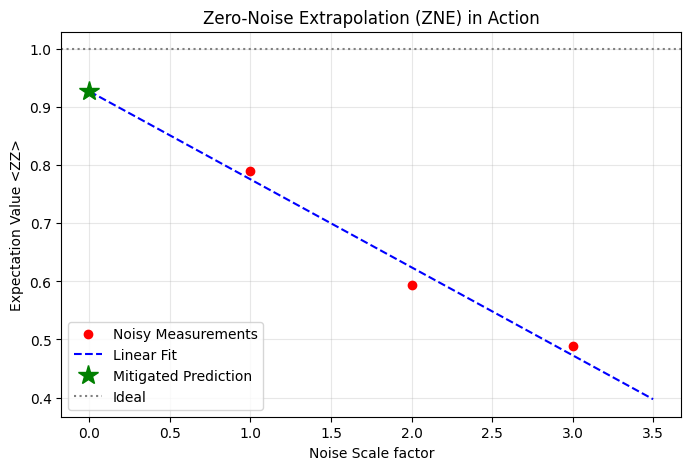

In [1]:
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, thermal_relaxation_error, ReadoutError

# --- 1. Define Scalable Noise Model ---
def build_scaled_noise_model(scale=1.0):
    """
    Returns a noise model where all error rates are multiplied by 'scale'.
    This mimics 'Pulse Stretching' (running gates slower).
    """
    # Baseline constants (same as Module 4, but scalable)
    # Note: Increasing scale means WORSE noise
    # For T1/T2: Worse means SHORTER time. So we DIVIDE by scale.
    t1 = 50e-6 / scale  
    t2 = 70e-6 / scale
    
    # For Readout: Worse means HIGHER probability. So we MULTIPLY by scale.
    readout_err = 0.05 * scale
    
    # 1-Qubit Errors
    error_1q = thermal_relaxation_error(t1, t2, 50e-9)
    
    # 2-Qubit Errors (Tensor Product)
    # We use .expand to ensure dimensions match the 2-qubit gate
    error_2q_single = thermal_relaxation_error(t1, t2, 400e-9)
    error_2q = error_2q_single.expand(error_2q_single)
    
    noise_model = NoiseModel()
    noise_model.add_all_qubit_quantum_error(error_1q, ['sx', 'x', 'id', 'rz'])
    noise_model.add_all_qubit_quantum_error(error_2q, ['ecr', 'cx'])
    
    # Limit readout error to max 0.5 (random guessing)
    p_ro = min(0.5, readout_err)
    probs = [[1 - p_ro, p_ro], [p_ro, 1 - p_ro]]
    noise_model.add_all_qubit_readout_error(ReadoutError(probs))
    
    return noise_model

# --- 2. ZNE Extrapolation Logic ---
def zne_extrapolate(noisy_values, noise_scales=[1, 2, 3]):
    """
    Fits a line to the noisy points and predicts value at scale=0.
    """
    X = np.array(noise_scales).reshape(-1, 1)
    y = np.array(noisy_values)
    
    model = LinearRegression()
    model.fit(X, y)
    
    zero_noise_val = model.predict([[0.0]])[0]
    return zero_noise_val, model

# --- 3. Run the Experiment ---
# A. Setup a Test Circuit (Bell State)
qc = QuantumCircuit(2)
qc.h(0)
qc.cx(0, 1)
qc.measure_all()
ideal_val = 1.0 # We expect <ZZ> = 1.0 (Correlated)

# B. Measure at different noise scales
scales = [1.0, 2.0, 3.0]
results = []

print("Running ZNE Experiments...")
for s in scales:
    # Build noise model for this scale
    nm = build_scaled_noise_model(scale=s)
    sim = AerSimulator(noise_model=nm)
    
    # Run
    job = sim.run(transpile(qc, sim), shots=2000)
    counts = job.result().get_counts()
    
    # Calculate Expectation <ZZ> = (P(00)+P(11)) - (P(01)+P(10))
    # If perfect, P(00)=0.5, P(11)=0.5 -> Exp = 1.0
    shots = sum(counts.values())
    p_even = (counts.get('00', 0) + counts.get('11', 0)) / shots
    p_odd = (counts.get('01', 0) + counts.get('10', 0)) / shots
    exp_val = p_even - p_odd
    
    results.append(exp_val)
    print(f"  Scale {s}x -> Expectation: {exp_val:.3f}")

# C. Extrapolate
mitigated, model = zne_extrapolate(results, scales)

print(f"\nResults:")
print(f"  Noisy Baseline (1x): {results[0]:.3f}")
print(f"  ZNE Mitigated (0x):  {mitigated:.3f}")
print(f"  Ideal Target:        {ideal_val:.3f}")

# D. Plot
plt.figure(figsize=(8, 5))
plt.plot(scales, results, 'ro', label='Noisy Measurements')
x_line = np.linspace(0, 3.5, 10)
plt.plot(x_line, model.predict(x_line.reshape(-1, 1)), 'b--', label='Linear Fit')
plt.plot(0, mitigated, 'g*', markersize=15, label='Mitigated Prediction')
plt.axhline(ideal_val, color='gray', linestyle=':', label='Ideal')
plt.xlabel('Noise Scale factor')
plt.ylabel('Expectation Value <ZZ>')
plt.title('Zero-Noise Extrapolation (ZNE) in Action')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()